In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm as tqdm, trange
from dataclasses import dataclass, field
from typing import Tuple, List, Any
from functools import partial
import pickle
import torch
from torch import nn
import torch.nn.functional as F

%matplotlib inline
sns.set_style("whitegrid")
sns.set_palette("colorblind")
plt.rcParams.update({'font.size': 14})

trange = partial(trange, position=0)
tqdm = partial(tqdm, position=0)

# Часть вторая: добавим нейронных сетей
Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду
ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в
том числе обобщаться на доски размера побольше).

## Пункт 3
Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов.
Замечание: скорее всего, experience replay потребуется сразу же.

In [2]:
from tic_tac_toe import TicTacToe
from contracts import State, Action, Strategy, RandomStrategy, TicTacToeWrapper
from dqn import (DQNAction, DQNState, TicTacToeDQNWrapper, DQNStrategy,
                 Experience, ExperienceBatch, ReplayMemory, DQNTrainer)

In [3]:
env = TicTacToeDQNWrapper(TicTacToe(3,3,3))

In [4]:
def show_test_game(env: TicTacToeWrapper,
                    crosses_strategy: Strategy,
                    naughts_strategy: Strategy,
                    show_only_final: bool = False):
    '''Играем тестовую партию между стратегиями, печатаем ход игры'''
    state, actions = env.reset()
    while True:
        if env.env.curTurn == 1:
            action = crosses_strategy.get_action(state, actions)
        else:
            action = naughts_strategy.get_action(state, actions)
        state, actions, crosses_reward, done = env.step(action)
        if not show_only_final:
            env.env.printBoard()
            print()
        if crosses_reward == 1:
            if show_only_final:
                env.env.printBoard()
            print("Крестики выиграли!")
            return
        if crosses_reward == -1:
            if show_only_final:
                env.env.printBoard()
            print("Нолики выиграли!")
            return
        if done:
            if show_only_final:
                env.env.printBoard()
            print("Ничья!")
            return

In [5]:
def run_episode(env: TicTacToeWrapper,
                        crosses_strategy: Strategy,
                        naughts_strategy: Strategy) -> int:
    """Генерирует эпизод по двум стратегиям, возвращает финальный reward для крестиков"""
    state, actions = env.reset()
    while True:
        if env.env.curTurn == 1:
            action = crosses_strategy.get_action(state, actions)
        else:
            action = naughts_strategy.get_action(state, actions)
        state, actions, crosses_reward, done = env.step(action)
        if done:
            return crosses_reward

In [6]:
@dataclass
class EvaluationResults:
    crosses_mean_reward: float
    naughts_mean_reward: float
    crosses_win_fraction: float
    naughts_win_fraction: float
    tie_fraction: float

In [7]:
def evaluate_strategy(env: TicTacToeWrapper,
                        crosses_strategy: Strategy,
                        naughts_strategy: Strategy,
                        num_iterations: int) -> EvaluationResults:
    """Генерирует num_iterations запусков по двум стратегиям
    и возвращает итоговые результаты"""
    crosses_rewards = [run_episode(env, crosses_strategy, naughts_strategy)
                                                for _ in trange(num_iterations)]
    crosses_rewards = np.array(crosses_rewards)
    crosses_mean_reward = crosses_rewards.mean()
    naughts_mean_reward = -crosses_mean_reward
    crosses_win_fraction = (crosses_rewards == 1).mean()
    naughts_win_fraction = (crosses_rewards == -1).mean()
    tie_fraction = (crosses_rewards == 0).mean()
    return EvaluationResults(crosses_mean_reward, naughts_mean_reward,
                             crosses_win_fraction, naughts_win_fraction, tie_fraction)

In [8]:
def save(obj: Any, path: str):
    with open(path, 'wb') as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)


def load(path) -> Any:
    with open(path, 'rb') as f:
        return pickle.load(f)

In [9]:
random_strategy = RandomStrategy()

In [10]:
show_test_game(env, random_strategy, random_strategy, True)

---- ---- ---- -
| x | o | x | 
---- ---- ---- -
| o | o | x | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -
Ничья!


## Учим стратегию играть против самой себя на поле 3x3
Как и в прошлой части, одновременно играем за обе стороны, а оценку проводим, играя против версии с прошлой эпохи

In [11]:
EPSILON = 0.5

In [12]:
@dataclass
class TrainHistory:
    crosses_mean_rewards: List[float] = field(default_factory=list)
    naughts_mean_rewards: List[float] = field(default_factory=list)
    crosses_win_fractions: List[float] = field(default_factory=list)
    naughts_win_fractions: List[float] = field(default_factory=list)
    tie_fractions: List[float] = field(default_factory=list)
       
    def append(self, result: EvaluationResults):
        self.crosses_mean_rewards.append(result.crosses_mean_reward)
        self.naughts_mean_rewards.append(result.naughts_mean_reward)
        self.crosses_win_fractions.append(result.crosses_win_fraction)
        self.naughts_win_fractions.append(result.naughts_win_fraction)
        self.tie_fractions.append(result.tie_fraction)

In [13]:
from copy import deepcopy


def train_and_eval(trainer: DQNTrainer,
                    train_iterations: int,
                    eval_iterations: int,
                    num_checkpoints: int,
                    fit_each_step: int = 2) -> Tuple[TrainHistory, TrainHistory]:
    #  Обучать будем по эпохам, оценивая качество после каждой из них
    epoch_iterations = int(train_iterations / num_checkpoints)
    crosses_history = TrainHistory()
    naughts_history = TrainHistory()
    n_cols = trainer.env.env.n_cols
    # После первой эпохи оцениваем игру против случайной стратегии
    eval_opponent_strategy = RandomStrategy()
    model = trainer.strategy.model
    print(f'Trainer: {trainer}', flush=True)
    print(f'Training {trainer.strategy} versus {trainer.strategy}', flush=True)
    for epoch in trange(num_checkpoints, desc='Epoch'):
        print(f'Epoch {epoch+1} of {num_checkpoints} ({epoch_iterations} runs)', flush=True)
        if epoch > 0:
            #  На последующих эпохах оцениваем игру против эпсилон-мягкой стратегии с прошлой эпохи
            previous_model = deepcopy(model)
            eval_opponent_strategy = DQNStrategy(previous_model, epsilon=EPSILON, n_cols=n_cols)
        # Собственно обучение
        trained_strategy = trainer.fit(epoch_iterations, fit_each_step)
        #  Будем оценивать игру обученной жадной стратегии
        eval_strategy = DQNStrategy(model, epsilon=0, n_cols=n_cols)

        crosses_results = evaluate_strategy(trainer.env,
                            crosses_strategy=eval_strategy,
                            naughts_strategy=eval_opponent_strategy,
                            num_iterations=eval_iterations)
        crosses_history.append(crosses_results)
        eval_str = f'{eval_strategy} results over {eval_iterations} games as %s versus {eval_opponent_strategy}'
        eval_str = f'{eval_str}:' if epoch == 0 else f'{eval_str} from previous epoch:'
        print(eval_str % 'crosses', flush=True)
        print(crosses_results, flush=True)
        print(flush=True)
        naughts_results = evaluate_strategy(trainer.env,
                            crosses_strategy=eval_opponent_strategy,
                            naughts_strategy=eval_strategy,
                            num_iterations=eval_iterations)
        naughts_history.append(naughts_results)
        print(eval_str % 'naughts', flush=True)
        print(naughts_results)
        # Ещё отрендерим партию текущей и прошлой жадных стратегий
        if epoch > 0:
            eval_opponent_strategy = DQNStrategy(previous_model, epsilon=0, n_cols=n_cols)
        header = f'{eval_strategy} from current epoch as %s versus {eval_opponent_strategy}'
        header = f'{header}:' if epoch == 0 else f'{header} from previous epoch:'
        print(header % 'crosses', flush=True)
        show_test_game(env, eval_strategy, eval_opponent_strategy)
        print(header % 'naughts', flush=True)
        show_test_game(env, eval_opponent_strategy, eval_strategy)
        print('\n', flush=True)
    return crosses_history, naughts_history

In [14]:
def plot_history(history: TrainHistory,
                 title: str,
                 train_iterations: int,
                 eval_iterations: int,
                 num_checkpoints: int):
    """Отрисовывает результаты обучения"""
    x_values = np.linspace(train_iterations/num_checkpoints, train_iterations, num_checkpoints)
    plt.figure(figsize=(15, 7))
    plt.plot(x_values, history.crosses_mean_rewards, label='Средний reward крестиков')
    plt.plot(x_values, history.naughts_mean_rewards, label='Средний reward ноликов')
    plt.plot(x_values, history.crosses_win_fractions, label='Доля побед крестиков')
    plt.plot(x_values, history.naughts_win_fractions, label='Доля побед ноликов')
    plt.plot(x_values, history.tie_fractions, label='Доля ничьих')
    plt.title(title, fontsize=16)
    plt.xlabel('Число итераций обучения', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.tight_layout()

In [15]:
class QNetwork(nn.Module):
    def __init__(self, num_filters=32, in_channels=2):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, num_filters, 3, padding=1)
        self.conv2 = nn.Conv2d(num_filters, num_filters, 3, padding=1)
        self.conv3 = nn.Conv2d(num_filters, 1, 1)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [16]:
model = QNetwork()

In [17]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

9889

In [18]:
dqn_strategy = DQNStrategy(model, epsilon=EPSILON, n_cols=env.env.n_cols)

In [19]:
trainer = DQNTrainer(env,
                    dqn_strategy,
                    batch_size=64,
                    learning_rate=0.001,
                    replay_memory_size=1000)

In [20]:
TRAIN_ITER = 500000
EVAL_ITER = 50000
NUM_CHECKPOINTS = 5

In [21]:
crosses_history, naughts_history = train_and_eval(trainer,
                                                    TRAIN_ITER,
                                                    EVAL_ITER,
                                                    NUM_CHECKPOINTS)

Trainer: <dqn.DQNTrainer object at 0x7f7afce33d60>
Training EpsilonGreedyDQNStrategy(epsilon=0.5) versus EpsilonGreedyDQNStrategy(epsilon=0.5)


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 of 5 (100000 runs)


100%|██████████| 50000/50000 [02:49<00:00, 294.84it/s]

GreedyDQNStrategy results over 50000 games as crosses versus RandomStrategy:
EvaluationResults(crosses_mean_reward=0.98958, naughts_mean_reward=-0.98958, crosses_win_fraction=0.98958, naughts_win_fraction=0.0, tie_fraction=0.01042)




100%|██████████| 50000/50000 [02:54<00:00, 287.18it/s]

GreedyDQNStrategy results over 50000 games as naughts versus RandomStrategy:
EvaluationResults(crosses_mean_reward=-0.897, naughts_mean_reward=0.897, crosses_win_fraction=0.01642, naughts_win_fraction=0.91342, tie_fraction=0.07016)
GreedyDQNStrategy from current epoch as crosses versus RandomStrategy:
---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   | o | 
---- ---- ---- -

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   | x | o | 
---- ---- ---- -

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x | o | 
---- ---- ---- -
|   | x | o | 
---- ---- ---- -

---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   | x | o | 
---- ---- ---- -
|   | x | o | 
---- ---- ---- -

Крестики выиграли!
GreedyDQNStrategy from current epoch as naughts versus RandomStrategy:
---- ---- ---- -
|   |   |   | 
---- 


Epoch:  20%|██        | 1/5 [24:56<1:39:44, 1496.11s/it]

Epoch 2 of 5 (100000 runs)


100%|██████████| 50000/50000 [04:10<00:00, 199.95it/s]

GreedyDQNStrategy results over 50000 games as crosses versus EpsilonGreedyDQNStrategy(epsilon=0.5) from previous epoch:
EvaluationResults(crosses_mean_reward=0.79468, naughts_mean_reward=-0.79468, crosses_win_fraction=0.79468, naughts_win_fraction=0.0, tie_fraction=0.20532)




100%|██████████| 50000/50000 [04:33<00:00, 182.89it/s]

GreedyDQNStrategy results over 50000 games as naughts versus EpsilonGreedyDQNStrategy(epsilon=0.5) from previous epoch:
EvaluationResults(crosses_mean_reward=-0.45576, naughts_mean_reward=0.45576, crosses_win_fraction=0.0302, naughts_win_fraction=0.46616, tie_fraction=0.50166)
GreedyDQNStrategy from current epoch as crosses versus GreedyDQNStrategy from previous epoch:
---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   | o | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   | o | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -

---- ---- ---- -
|   | o | o | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -

---- ---- ---- -
| x | o | o | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -

---- ---- ---- -
| x | o | o | 
---- ---- ---- -
|   | x |


Epoch:  40%|████      | 2/5 [53:16<1:17:52, 1557.41s/it]

Epoch 3 of 5 (100000 runs)


100%|██████████| 50000/50000 [04:02<00:00, 206.27it/s]

GreedyDQNStrategy results over 50000 games as crosses versus EpsilonGreedyDQNStrategy(epsilon=0.5) from previous epoch:
EvaluationResults(crosses_mean_reward=0.7955, naughts_mean_reward=-0.7955, crosses_win_fraction=0.7955, naughts_win_fraction=0.0, tie_fraction=0.2045)




100%|██████████| 50000/50000 [04:13<00:00, 197.57it/s]

GreedyDQNStrategy results over 50000 games as naughts versus EpsilonGreedyDQNStrategy(epsilon=0.5) from previous epoch:
EvaluationResults(crosses_mean_reward=-0.4684, naughts_mean_reward=0.4684, crosses_win_fraction=0.02198, naughts_win_fraction=0.49038, tie_fraction=0.48764)
GreedyDQNStrategy from current epoch as crosses versus GreedyDQNStrategy from previous epoch:


---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
| o |   |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
| o |   | x | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
| o |   | x | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
| o |   |   | 
---- ---- ---- -

---- ---- ---- -
| o |   | x | 
---- ---- ---- -
| x | x |   | 
---- ---- ---- -
| o |   |   | 
---- ---- ---- -

---- ---- ---- -
| o |   | x | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -
| o |   |   | 
---- ---- ---- -

---- ---- ---- -
| o | x | x | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -
| o |   |   | 
---- ---- ---- -

---- ---- ---- -
| o | x | x | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -
| o | o |   | 
---- ---- ---- -

---- ---- ---- -
| o | x | x | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -
| o | o

Epoch:  60%|██████    | 3/5 [1:20:44<52:49, 1584.51s/it]

Epoch 4 of 5 (100000 runs)


100%|██████████| 50000/50000 [04:02<00:00, 205.95it/s]

GreedyDQNStrategy results over 50000 games as crosses versus EpsilonGreedyDQNStrategy(epsilon=0.5) from previous epoch:
EvaluationResults(crosses_mean_reward=0.79198, naughts_mean_reward=-0.79198, crosses_win_fraction=0.79198, naughts_win_fraction=0.0, tie_fraction=0.20802)




100%|██████████| 50000/50000 [04:10<00:00, 199.34it/s]

GreedyDQNStrategy results over 50000 games as naughts versus EpsilonGreedyDQNStrategy(epsilon=0.5) from previous epoch:
EvaluationResults(crosses_mean_reward=-0.54216, naughts_mean_reward=0.54216, crosses_win_fraction=0.0128, naughts_win_fraction=0.55496, tie_fraction=0.43224)
GreedyDQNStrategy from current epoch as crosses versus GreedyDQNStrategy from previous epoch:
---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   | o | 
---- ---- ---- -

---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   | o | 
---- ---- ---- -

---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   | o | o | 
---- ---- ---- -

---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
| x | o | o | 
---- ---- ---- -

---- ---- ---- -
|   | x | o | 
---- ---- ---- -
|   | x |


Epoch:  80%|████████  | 4/5 [1:48:01<26:40, 1600.27s/it]

Epoch 5 of 5 (100000 runs)


100%|██████████| 50000/50000 [04:28<00:00, 186.17it/s]

GreedyDQNStrategy results over 50000 games as crosses versus EpsilonGreedyDQNStrategy(epsilon=0.5) from previous epoch:
EvaluationResults(crosses_mean_reward=0.73602, naughts_mean_reward=-0.73602, crosses_win_fraction=0.76102, naughts_win_fraction=0.0, tie_fraction=0.23648)




100%|██████████| 50000/50000 [04:31<00:00, 183.93it/s]

GreedyDQNStrategy results over 50000 games as naughts versus EpsilonGreedyDQNStrategy(epsilon=0.5) from previous epoch:
EvaluationResults(crosses_mean_reward=-0.46186, naughts_mean_reward=0.46186, crosses_win_fraction=0.0, naughts_win_fraction=0.42386, tie_fraction=0.57234)
GreedyDQNStrategy from current epoch as crosses versus GreedyDQNStrategy from previous epoch:
---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   | o | 
---- ---- ---- -

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
| x |   | o | 
---- ---- ---- -

---- ---- ---- -
|   |   | o | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
| x |   | o | 
---- ---- ---- -

---- ---- ---- -
|   |   | o | 
---- ---- ---- -
|   | x | x | 
---- ---- ---- -
| x |   | o | 
---- ---- ---- -

---- ---- ---- -
|   |   | o | 
---- ---- ---- -
| o | x | x 


Epoch: 100%|██████████| 5/5 [2:23:22<00:00, 1720.55s/it]


In [22]:
path = 'models/dqn_weights_3x3.pt'
torch.save(model.state_dict(), path)
# Проверяем, что всё работает
model.load_state_dict(torch.load(path))
model.eval();

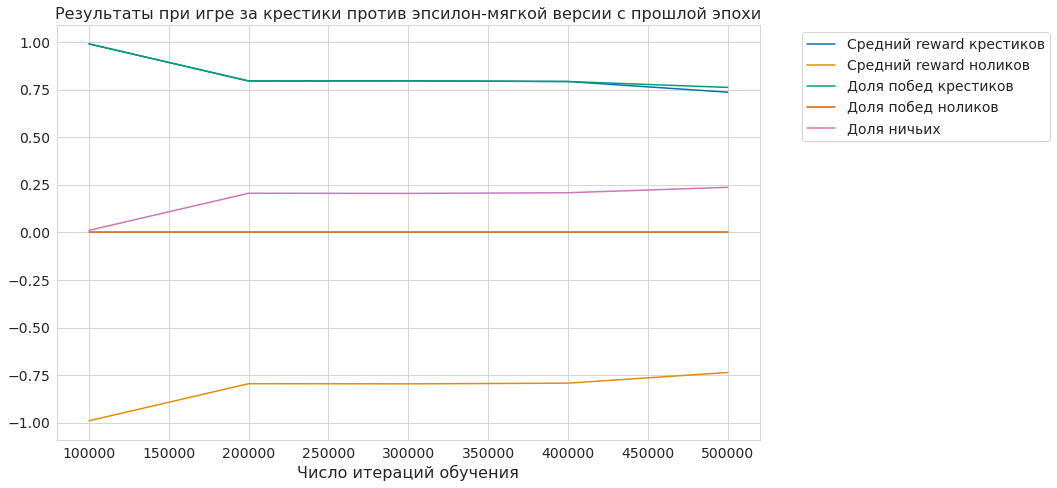

In [23]:
plot_history(crosses_history,
            'Результаты при игре за крестики против эпсилон-мягкой версии с прошлой эпохи',
            TRAIN_ITER,
            EVAL_ITER,
            NUM_CHECKPOINTS)

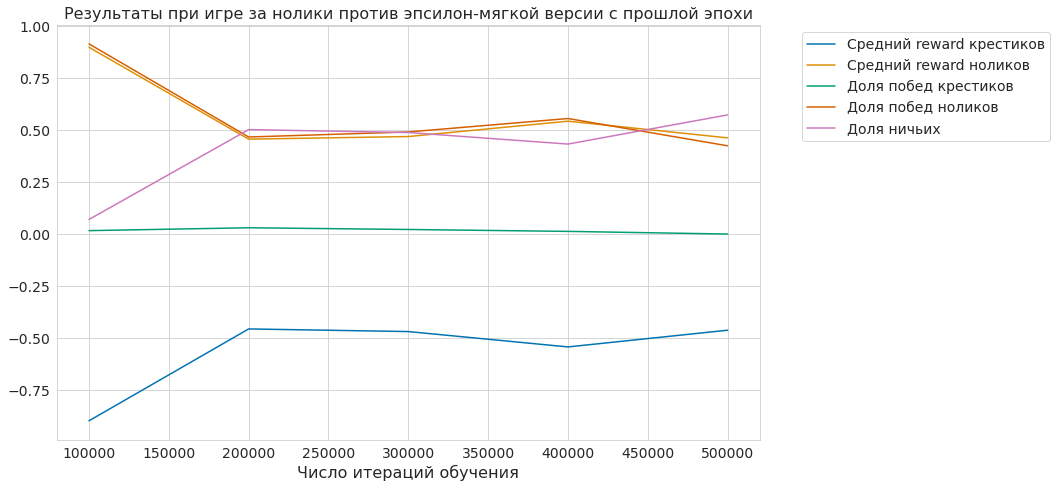

In [24]:
plot_history(naughts_history,
            'Результаты при игре за нолики против эпсилон-мягкой версии с прошлой эпохи',
            TRAIN_ITER,
            EVAL_ITER,
            NUM_CHECKPOINTS)

In [25]:
print('Доли поражений при игре за нолики')
naughts_history.crosses_win_fractions

Доли поражений при игре за нолики


[0.01642, 0.0302, 0.02198, 0.0128, 0.0]

Если теперь обученная стратегия сыграет против самой себя?

In [26]:
greedy_dqn_strategy = DQNStrategy(model, epsilon=0, n_cols=env.env.n_cols)

In [27]:
show_test_game(env, greedy_dqn_strategy, greedy_dqn_strategy)

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
| o |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x | x | 
---- ---- ---- -
| o |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
| o | x | x | 
---- ---- ---- -
| o |   |   | 
---- ---- ---- -

---- ---- ---- -
| x |   |   | 
---- ---- ---- -
| o | x | x | 
---- ---- ---- -
| o |   |   | 
---- ---- ---- -

---- ---- ---- -
| x |   |   | 
---- ---- ---- -
| o | x | x | 
---- ---- ---- -
| o |   | o | 
---- ---- ---- -

---- ---- ---- -
| x |   |   | 
---- ---- ---- -
| o | x | x | 
---- ---- ---- -
| o | x | o | 
---- ---- ---- -

---- ---- ---- -
| x | o |   | 
---- ---- ---- -
| o | x | x | 
---- ---- ---- -
| o | x | o | 
---- ---- ---- -

---- ---- ---- -
| x | o | x | 
---- ---- ---- -
| o | x | x | 
---- ---- ---- -
| o | x

А против случайной стратегии?

In [28]:
evaluate_strategy(env, greedy_dqn_strategy, random_strategy, EVAL_ITER)

100%|██████████| 50000/50000 [03:12<00:00, 260.31it/s]


EvaluationResults(crosses_mean_reward=0.98604, naughts_mean_reward=-0.98604, crosses_win_fraction=0.98604, naughts_win_fraction=0.0, tie_fraction=0.01396)

In [29]:
evaluate_strategy(env, random_strategy, greedy_dqn_strategy, EVAL_ITER)

100%|██████████| 50000/50000 [03:03<00:00, 271.76it/s]


EvaluationResults(crosses_mean_reward=-0.9241, naughts_mean_reward=0.9241, crosses_win_fraction=0.0, naughts_win_fraction=0.8815, tie_fraction=0.11424)

In [30]:
show_test_game(env, greedy_dqn_strategy, random_strategy)

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x | o | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x | o | 
---- ---- ---- -
| x |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x | o | 
---- ---- ---- -
| x | o |   | 
---- ---- ---- -

---- ---- ---- -
|   |   | x | 
---- ---- ---- -
|   | x | o | 
---- ---- ---- -
| x | o |   | 
---- ---- ---- -

Крестики выиграли!


In [31]:
show_test_game(env, random_strategy, greedy_dqn_strategy)

---- ---- ---- -
| x |   |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
| x |   |   | 
---- ---- ---- -
|   | o |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
| x | x |   | 
---- ---- ---- -
|   | o |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
| x | x | o | 
---- ---- ---- -
|   | o |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
| x | x | o | 
---- ---- ---- -
|   | o |   | 
---- ---- ---- -
|   |   | x | 
---- ---- ---- -

---- ---- ---- -
| x | x | o | 
---- ---- ---- -
|   | o |   | 
---- ---- ---- -
| o |   | x | 
---- ---- ---- -

Нолики выиграли!


#### Сыграем проив стратегии, обученной в первой части

In [32]:
self_play_q_3x3 = load('models/self_play_q_3x3.pkl')

In [33]:
from qlearning import EpsilonGreedyStrategy

In [34]:
q_3x3_strategy = EpsilonGreedyStrategy(0, self_play_q_3x3)

In [35]:
show_test_game(env, greedy_dqn_strategy, q_3x3_strategy)

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   | o | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   | o | 
---- ---- ---- -
|   | x | x | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   | o | 
---- ---- ---- -
| o | x | x | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
| x |   | o | 
---- ---- ---- -
| o | x | x | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
| x |   | o | 
---- ---- ---- -
| o | x | x | 
---- ---- ---- -
|   |   | o | 
---- ---- ---- -

---- ---- ---- -
| x |   | o | 
---- ---- ---- -
| o | x | x | 
---- ---- ---- -
|   | x | o | 
---- ---- ---- -

---- ---- ---- -
| x | o | o | 
---- ---- ---- -
| o | x | x | 
---- ---- ---- -
|   | x | o | 
---- ---- ---- -

---- ---- ---- -
| x | o | o | 
---- ---- ---- -
| o | x | x | 
---- ---- ---- -
| x | x

In [36]:
show_test_game(env, q_3x3_strategy, greedy_dqn_strategy)

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
| o |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
| x | x |   | 
---- ---- ---- -
| o |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -
| o |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -
| o | x |   | 
---- ---- ---- -

---- ---- ---- -
|   | o |   | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -
| o | x |   | 
---- ---- ---- -

---- ---- ---- -
|   | o |   | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -
| o | x | x | 
---- ---- ---- -

---- ---- ---- -
| o | o |   | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -
| o | x | x | 
---- ---- ---- -

---- ---- ---- -
| o | o | x | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -
| o | x

## Пункт 4
Реализуйте Double DQN и/или Dueling DQN.  

Реализуем Dueling DQN

In [37]:
class DuelingQNetwork(nn.Module):
    def __init__(self, num_filters=32, in_channels=2):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, num_filters, 3, padding=1)
        self.conv2 = nn.Conv2d(num_filters, num_filters, 3, padding=1)

        self.v_conv1 = nn.Conv2d(num_filters, 1, 1)
        self.v_conv2 = nn.Conv2d(1, 1, 3, padding=0)

        self.a_conv = nn.Conv2d(num_filters, 1, 1)

    def forward(self, x):
        batch_size = x.shape[0]
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        
        v = F.leaky_relu(self.v_conv1(x))
        v = self.v_conv2(v)
        
        a = self.a_conv(x)
        a_mean = a.view(batch_size, -1).mean(-1).reshape(batch_size, 1, 1, 1)
        q = v + (a - a_mean)
        
        return q

In [38]:
dueling_model = DuelingQNetwork()

In [39]:
sum(p.numel() for p in dueling_model.parameters() if p.requires_grad)

9932

In [40]:
dueling_dqn_strategy = DQNStrategy(dueling_model, epsilon=EPSILON, n_cols=env.env.n_cols)

In [41]:
dueling_trainer = DQNTrainer(env,
                        dueling_dqn_strategy,
                        batch_size=64,
                        learning_rate=0.001,
                        replay_memory_size=1000)

In [42]:
TRAIN_ITER = 500000
EVAL_ITER = 50000
NUM_CHECKPOINTS = 5

In [43]:
dueling_crosses_history, dueling_naughts_history = train_and_eval(dueling_trainer,
                                                                    TRAIN_ITER,
                                                                    EVAL_ITER,
                                                                    NUM_CHECKPOINTS)

Trainer: <dqn.DQNTrainer object at 0x7f7afce38c70>
Training EpsilonGreedyDQNStrategy(epsilon=0.5) versus EpsilonGreedyDQNStrategy(epsilon=0.5)


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 of 5 (100000 runs)


100%|██████████| 50000/50000 [03:46<00:00, 220.99it/s]

GreedyDQNStrategy results over 50000 games as crosses versus RandomStrategy:
EvaluationResults(crosses_mean_reward=0.9296, naughts_mean_reward=-0.9296, crosses_win_fraction=0.9844, naughts_win_fraction=0.0, tie_fraction=0.01012)




100%|██████████| 50000/50000 [03:43<00:00, 223.43it/s]

GreedyDQNStrategy results over 50000 games as naughts versus RandomStrategy:
EvaluationResults(crosses_mean_reward=-0.89984, naughts_mean_reward=0.89984, crosses_win_fraction=0.01204, naughts_win_fraction=0.91188, tie_fraction=0.07608)
GreedyDQNStrategy from current epoch as crosses versus RandomStrategy:


---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x | o | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
| x |   |   | 
---- ---- ---- -
|   | x | o | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
| x |   |   | 
---- ---- ---- -
|   | x | o | 
---- ---- ---- -
|   |   | o | 
---- ---- ---- -

---- ---- ---- -
| x |   | x | 
---- ---- ---- -
|   | x | o | 
---- ---- ---- -
|   |   | o | 
---- ---- ---- -

---- ---- ---- -
| x |   | x | 
---- ---- ---- -
| o | x | o | 
---- ---- ---- -
|   |   | o | 
---- ---- ---- -

---- ---- ---- -
| x | x | x | 
---- ---- ---- -
| o | x | o | 
---- ---- ---- -
|   |   | o | 
---- ---- ---- -

Крестики выиграли!
GreedyDQNStrategy from current epoch as naughts versus RandomStrategy:
---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   |   | x | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

Epoch:  20%|██        | 1/5 [31:24<2:05:37, 1884.30s/it]

Epoch 2 of 5 (100000 runs)


100%|██████████| 50000/50000 [05:39<00:00, 147.17it/s]

GreedyDQNStrategy results over 50000 games as crosses versus EpsilonGreedyDQNStrategy(epsilon=0.5) from previous epoch:
EvaluationResults(crosses_mean_reward=0.62412, naughts_mean_reward=-0.62412, crosses_win_fraction=0.79352, naughts_win_fraction=0.0, tie_fraction=0.18954)




100%|██████████| 50000/50000 [05:54<00:00, 141.23it/s]

GreedyDQNStrategy results over 50000 games as naughts versus EpsilonGreedyDQNStrategy(epsilon=0.5) from previous epoch:
EvaluationResults(crosses_mean_reward=-0.4043, naughts_mean_reward=0.4043, crosses_win_fraction=0.0297, naughts_win_fraction=0.434, tie_fraction=0.5363)
GreedyDQNStrategy from current epoch as crosses versus GreedyDQNStrategy from previous epoch:


---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   | o | 
---- ---- ---- -

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
| x | x |   | 
---- ---- ---- -
|   |   | o | 
---- ---- ---- -

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -
|   |   | o | 
---- ---- ---- -

---- ---- ---- -
|   |   | x | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -
|   |   | o | 
---- ---- ---- -

---- ---- ---- -
|   |   | x | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -
| o |   | o | 
---- ---- ---- -

---- ---- ---- -
|   |   | x | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -
| o | x | o | 
---- ---- ---- -

---- ---- ---- -
|   | o | x | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -
| o | x | o | 
---- ---- ---- -

---- ---- ---- -
| x | o | x | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -
| o | x

Epoch:  40%|████      | 2/5 [1:06:57<1:37:56, 1958.84s/it]

Epoch 3 of 5 (100000 runs)


100%|██████████| 50000/50000 [05:15<00:00, 158.54it/s]

GreedyDQNStrategy results over 50000 games as crosses versus EpsilonGreedyDQNStrategy(epsilon=0.5) from previous epoch:
EvaluationResults(crosses_mean_reward=0.56318, naughts_mean_reward=-0.56318, crosses_win_fraction=0.76098, naughts_win_fraction=0.0, tie_fraction=0.21924)




100%|██████████| 50000/50000 [05:43<00:00, 145.46it/s]

GreedyDQNStrategy results over 50000 games as naughts versus EpsilonGreedyDQNStrategy(epsilon=0.5) from previous epoch:
EvaluationResults(crosses_mean_reward=-0.62048, naughts_mean_reward=0.62048, crosses_win_fraction=0.0, naughts_win_fraction=0.53768, tie_fraction=0.45404)
GreedyDQNStrategy from current epoch as crosses versus GreedyDQNStrategy from previous epoch:
---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
| o |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
| x | x |   | 
---- ---- ---- -
| o |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -
| o |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -
| o | x |   | 
---- ---- ---- -

---- ---- ---- -
|   | o |   | 
---- ---- ---- -
| x | x | o 

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
| o |   |   | 
---- ---- ---- -

---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
| o |   |   | 
---- ---- ---- -

---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
| o | o |   | 
---- ---- ---- -

---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
| o | o | x | 
---- ---- ---- -

---- ---- ---- -
| o | x |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
| o | o | x | 
---- ---- ---- -

---- ---- ---- -
| o | x |   | 
---- ---- ---- -
| x | x |   | 
---- ---- ---- -
| o | o | x | 
---- ---- ---- -

---- ---- ---- -
| o | x |   | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -
| o | o | x | 
---- ---- ---- -

---- ---- ---- -
| o | x | x | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -
| o | o

Epoch:  60%|██████    | 3/5 [1:44:34<1:08:17, 2048.51s/it]

Epoch 4 of 5 (100000 runs)


100%|██████████| 50000/50000 [05:11<00:00, 160.47it/s]

GreedyDQNStrategy results over 50000 games as crosses versus EpsilonGreedyDQNStrategy(epsilon=0.5) from previous epoch:
EvaluationResults(crosses_mean_reward=0.7964, naughts_mean_reward=-0.7964, crosses_win_fraction=0.7964, naughts_win_fraction=0.0, tie_fraction=0.2036)




100%|██████████| 50000/50000 [05:46<00:00, 144.10it/s]


GreedyDQNStrategy results over 50000 games as naughts versus EpsilonGreedyDQNStrategy(epsilon=0.5) from previous epoch:
EvaluationResults(crosses_mean_reward=-0.55188, naughts_mean_reward=0.55188, crosses_win_fraction=0.0, naughts_win_fraction=0.55188, tie_fraction=0.44812)
GreedyDQNStrategy from current epoch as crosses versus GreedyDQNStrategy from previous epoch:
---- ---- ---- -
|   |   | x | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   | x | 
---- ---- ---- -
|   | o |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   | x | 
---- ---- ---- -
|   | o | x | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   | x | 
---- ---- ---- -
|   | o | x | 
---- ---- ---- -
|   |   | o | 
---- ---- ---- -

---- ---- ---- -
| x |   | x | 
---- ---- ---- -
|   | o | x | 
---- ---- ---- -
|   |   | o | 
---- ---- ---- -

---- ---- ---- -
| x | o | x | 
---- ---- ---- -
|   | o | x 

Epoch:  80%|████████  | 4/5 [2:19:52<34:29, 2069.17s/it]  

Epoch 5 of 5 (100000 runs)


100%|██████████| 50000/50000 [05:28<00:00, 152.29it/s]

GreedyDQNStrategy results over 50000 games as crosses versus EpsilonGreedyDQNStrategy(epsilon=0.5) from previous epoch:
EvaluationResults(crosses_mean_reward=0.79746, naughts_mean_reward=-0.79746, crosses_win_fraction=0.79746, naughts_win_fraction=0.0, tie_fraction=0.20254)




100%|██████████| 50000/50000 [05:43<00:00, 145.60it/s]

GreedyDQNStrategy results over 50000 games as naughts versus EpsilonGreedyDQNStrategy(epsilon=0.5) from previous epoch:
EvaluationResults(crosses_mean_reward=-0.59436, naughts_mean_reward=0.59436, crosses_win_fraction=0.0, naughts_win_fraction=0.59436, tie_fraction=0.40564)
GreedyDQNStrategy from current epoch as crosses versus GreedyDQNStrategy from previous epoch:
---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   | o | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   | o | 
---- ---- ---- -
| x | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   | o | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   | o | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -
|   |   | x | 
---- ---- ---- -

---- ---- ---- -
| o |   | o | 
---- ---- ---- -
| x | x | o 


Epoch: 100%|██████████| 5/5 [2:55:44<00:00, 2108.88s/it]


In [44]:
path = 'models/dueling_dqn_weights_3x3.pt'
torch.save(dueling_model.state_dict(), path)
# Проверяем, что всё работает
dueling_model.load_state_dict(torch.load(path))
dueling_model.eval();

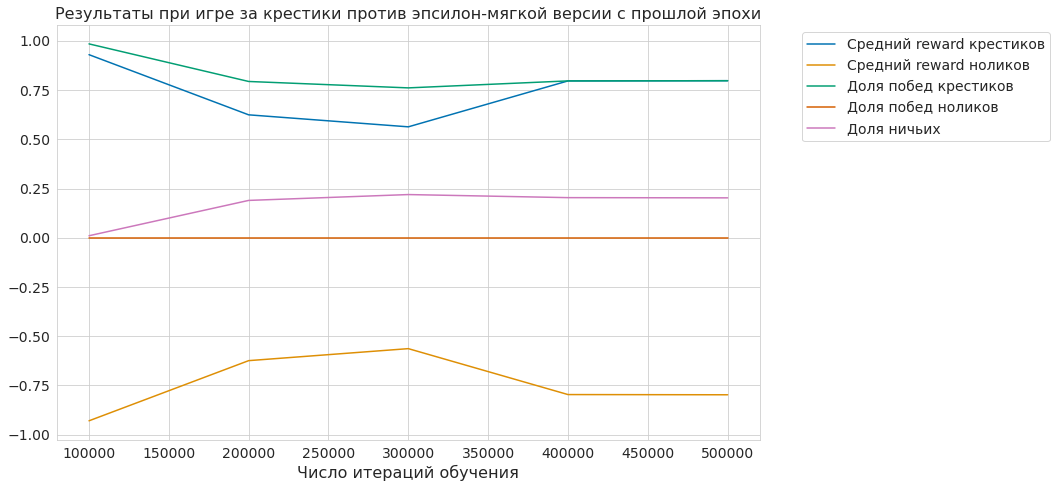

In [45]:
plot_history(dueling_crosses_history,
            'Результаты при игре за крестики против эпсилон-мягкой версии с прошлой эпохи',
            TRAIN_ITER,
            EVAL_ITER,
            NUM_CHECKPOINTS)

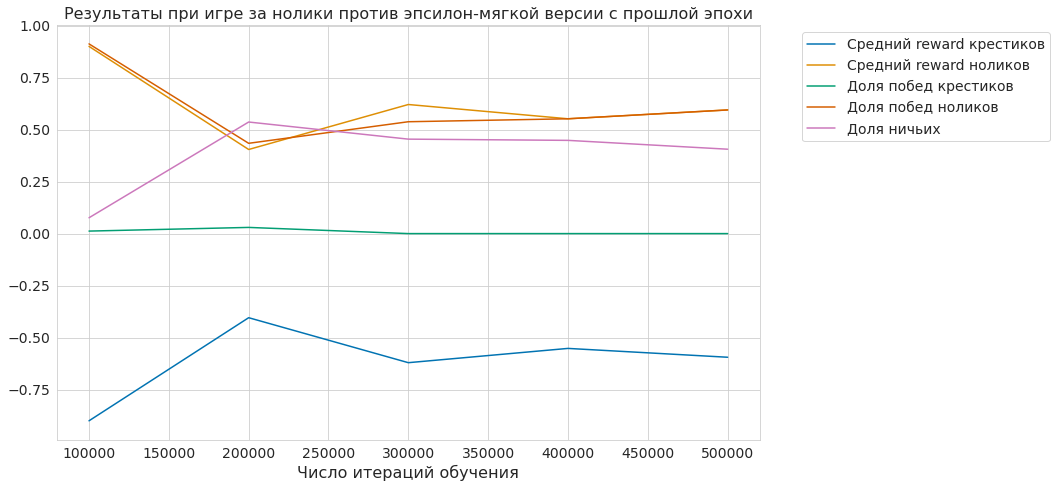

In [46]:
plot_history(dueling_naughts_history,
            'Результаты при игре за нолики против эпсилон-мягкой версии с прошлой эпохи',
            TRAIN_ITER,
            EVAL_ITER,
            NUM_CHECKPOINTS)

In [47]:
print('Доли поражений при игре за нолики')
dueling_naughts_history.crosses_win_fractions

Доли поражений при игре за нолики


[0.01204, 0.0297, 0.0, 0.0, 0.0]

Если теперь обученная стратегия сыграет против самой себя?

In [48]:
greedy_dueling_dqn_strategy = DQNStrategy(dueling_model, epsilon=0, n_cols=env.env.n_cols)

In [49]:
show_test_game(env, greedy_dueling_dqn_strategy, greedy_dueling_dqn_strategy)

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   | o | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   | o | 
---- ---- ---- -
| x | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   | o | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   | o | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -
|   |   | x | 
---- ---- ---- -

---- ---- ---- -
| o |   | o | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -
|   |   | x | 
---- ---- ---- -

---- ---- ---- -
| o | x | o | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -
|   |   | x | 
---- ---- ---- -

---- ---- ---- -
| o | x | o | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -
|   | o | x | 
---- ---- ---- -

---- ---- ---- -
| o | x | o | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -
| x | o

А против случайной стратегии?

In [50]:
evaluate_strategy(env, greedy_dueling_dqn_strategy, random_strategy, EVAL_ITER)

100%|██████████| 50000/50000 [03:55<00:00, 212.33it/s]


EvaluationResults(crosses_mean_reward=0.98936, naughts_mean_reward=-0.98936, crosses_win_fraction=0.98936, naughts_win_fraction=0.0, tie_fraction=0.01064)

In [51]:
evaluate_strategy(env, random_strategy, greedy_dueling_dqn_strategy, EVAL_ITER)

100%|██████████| 50000/50000 [03:46<00:00, 220.67it/s]


EvaluationResults(crosses_mean_reward=-0.90678, naughts_mean_reward=0.90678, crosses_win_fraction=0.0, naughts_win_fraction=0.90678, tie_fraction=0.09322)

In [52]:
show_test_game(env, greedy_dueling_dqn_strategy, random_strategy)

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
| o | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
| o | x |   | 
---- ---- ---- -
|   |   | x | 
---- ---- ---- -

---- ---- ---- -
| o |   |   | 
---- ---- ---- -
| o | x |   | 
---- ---- ---- -
|   |   | x | 
---- ---- ---- -

---- ---- ---- -
| o |   |   | 
---- ---- ---- -
| o | x |   | 
---- ---- ---- -
| x |   | x | 
---- ---- ---- -

---- ---- ---- -
| o |   | o | 
---- ---- ---- -
| o | x |   | 
---- ---- ---- -
| x |   | x | 
---- ---- ---- -

---- ---- ---- -
| o |   | o | 
---- ---- ---- -
| o | x |   | 
---- ---- ---- -
| x | x | x | 
---- ---- ---- -

Крестики выиграли!


In [53]:
show_test_game(env, random_strategy, greedy_dueling_dqn_strategy)

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   | o | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   | o | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -

---- ---- ---- -
|   | o | o | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -

---- ---- ---- -
|   | o | o | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
| x | x |   | 
---- ---- ---- -

---- ---- ---- -
| o | o | o | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
| x | x |   | 
---- ---- ---- -

Нолики выиграли!


#### Сыграем проив стратегии, обученной в первой части

In [54]:
show_test_game(env, greedy_dueling_dqn_strategy, q_3x3_strategy)

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   | o | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   | o | 
---- ---- ---- -
| x | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   | o | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   | o | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -
|   |   | x | 
---- ---- ---- -

---- ---- ---- -
| o |   | o | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -
|   |   | x | 
---- ---- ---- -

---- ---- ---- -
| o | x | o | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -
|   |   | x | 
---- ---- ---- -

---- ---- ---- -
| o | x | o | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -
|   | o | x | 
---- ---- ---- -

---- ---- ---- -
| o | x | o | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -
| x | o

In [55]:
show_test_game(env, q_3x3_strategy, greedy_dueling_dqn_strategy)

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   | o | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   | o | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
| x |   |   | 
---- ---- ---- -

---- ---- ---- -
| o |   | o | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
| x |   |   | 
---- ---- ---- -

---- ---- ---- -
| o | x | o | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
| x |   |   | 
---- ---- ---- -

---- ---- ---- -
| o | x | o | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
| x | o |   | 
---- ---- ---- -

---- ---- ---- -
| o | x | o | 
---- ---- ---- -
| x | x |   | 
---- ---- ---- -
| x | o |   | 
---- ---- ---- -

---- ---- ---- -
| o | x | o | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -
| x | o |   | 
---- ---- ---- -

---- ---- ---- -
| o | x | o | 
---- ---- ---- -
| x | x | o | 
---- ---- ---- -
| x | o

И против обычной DQN

In [56]:
show_test_game(env, greedy_dueling_dqn_strategy, greedy_dqn_strategy)

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
| o |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
| o | x |   | 
---- ---- ---- -

---- ---- ---- -
|   | o |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
| o | x |   | 
---- ---- ---- -

---- ---- ---- -
|   | o |   | 
---- ---- ---- -
|   | x | x | 
---- ---- ---- -
| o | x |   | 
---- ---- ---- -

---- ---- ---- -
|   | o |   | 
---- ---- ---- -
| o | x | x | 
---- ---- ---- -
| o | x |   | 
---- ---- ---- -

---- ---- ---- -
| x | o |   | 
---- ---- ---- -
| o | x | x | 
---- ---- ---- -
| o | x |   | 
---- ---- ---- -

---- ---- ---- -
| x | o |   | 
---- ---- ---- -
| o | x | x | 
---- ---- ---- -
| o | x | o | 
---- ---- ---- -

---- ---- ---- -
| x | o | x | 
---- ---- ---- -
| o | x | x | 
---- ---- ---- -
| o | x

In [57]:
show_test_game(env, greedy_dqn_strategy, greedy_dueling_dqn_strategy)

---- ---- ---- -
|   |   |   | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   | o | 
---- ---- ---- -
|   | x |   | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   | o | 
---- ---- ---- -
|   | x | x | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
|   |   | o | 
---- ---- ---- -
| o | x | x | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
| x |   | o | 
---- ---- ---- -
| o | x | x | 
---- ---- ---- -
|   |   |   | 
---- ---- ---- -

---- ---- ---- -
| x |   | o | 
---- ---- ---- -
| o | x | x | 
---- ---- ---- -
|   |   | o | 
---- ---- ---- -

---- ---- ---- -
| x |   | o | 
---- ---- ---- -
| o | x | x | 
---- ---- ---- -
|   | x | o | 
---- ---- ---- -

---- ---- ---- -
| x | o | o | 
---- ---- ---- -
| o | x | x | 
---- ---- ---- -
|   | x | o | 
---- ---- ---- -

---- ---- ---- -
| x | o | o | 
---- ---- ---- -
| o | x | x | 
---- ---- ---- -
| x | x